In [0]:
!pip install tweet-preprocessor
import pandas as pd
import numpy as np
import scipy as sp
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from copy import deepcopy

nltk.download('stopwords')
from nltk.stem import PorterStemmer 
from sklearn.metrics import f1_score, accuracy_score
import preprocessor as p

  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-cp36-none-any.whl size=7947 sha256=559ddd6783055c7a584018f6681dfa1eb827038f324de0343652a6227f12c8aa
  Stored in directory: /root/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
Successfully built tweet-preprocessor
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv("/content/drive/My Drive/WebProject/labeledTrainData.csv", delimiter="\t",names=["tweet", "label", "labelValue"])
#data = pd.read_csv("/content/drive/My Drive/WebProject/preprocessed_tweets.csv", delimiter="\t",names=["tweet", "label", "labelValue"])

In [0]:
data["label"].replace({"spam": "neutral", "normal": "neutral"}, inplace=True)
data["label"].replace({"neutral":1, "abusive": 2,"hateful":3}, inplace=True)

#data.head()


In [0]:
def preprocess_tweet(tweet):

    # 1. Remove URLs, emojis, mentions, smileys using tweet-preprocessor library
    # should not remove hashtags as hashtags contains important tweet content.
    
    #p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION,p.OPT.RESERVED,	p.OPT.SMILEY,p.OPT.NUMBER)
    clean = p.clean(tweet)
    # 2. Remove HTML tags using Beautiful soup library
    no_tag = BeautifulSoup(clean).get_text()

    # 3. Expanding hashtags.
    
    #tweets_expanded = expand_hashtags(no_tag)

    # 4. Remove non letter char using re
    letters_only = re.sub("[^a-zA-Z]"," ", no_tag)
    #letters_only = re.sub("[^a-zA-Z]"," ", tweets_expanded)
    
    # 5. Convert to lower case
    lower_case = letters_only.lower()
    words = lower_case.split()

    new_words = []
    ps = PorterStemmer() 
    for w in words:
        new_words.append(ps.stem(w))
    # for w in words:
    #     new_words.append(w)
    # print(new_words[0:4])
    
    # 5. Remove stop words
    stops = set(stopwords.words("english")) 
    final_words = [w for w in new_words if not w in stops]
    # final_words = new_words

    return(" ".join( final_words ))

In [0]:
data['tweet'][0]

'Beats by Dr. Dre urBeats Wired In-Ear Headphones - White https://t.co/9tREpqfyW4 https://t.co/FCaWyWRbpE'

In [0]:
num_tweets = data["tweet"].size
# print(num_tweets)
for i in range(num_tweets):
    data["tweet"][i] = preprocess_tweet(data["tweet"][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
data.head()

,tweet,label,labelValue
0,beat dr dre urbeat wire ear headphon white,1,4
1,man would fuck rule parti wa perpetu warfar,2,4
2,time draw close father draw near alway,1,4
3,notic start act differ distant bc peep someth ...,1,5
4,forget unfollow believ grow new follow last da...,1,3


In [0]:
df = data

In [0]:
data.drop(columns="labelValue", inplace=True)

In [0]:
df.head()

,tweet,label
0,beat dr dre urbeat wire ear headphon white,1
1,man would fuck rule parti wa perpetu warfar,2
2,time draw close father draw near alway,1
3,notic start act differ distant bc peep someth ...,1
4,forget unfollow believ grow new follow last da...,1


In [0]:
data['tweet_length'] = [len(text.split(' ')) for text in data.tweet]

data['tweet_length'].value_counts()

9     10983
10    10893
8     10645
7      9894
11     9528
6      8373
12     7532
5      6969
13     5672
4      5660
3      3423
14     3400
2      2104
15     1955
16     1081
1       856
17      572
18      244
19      115
20       54
22       14
21       13
23        6
24        5
25        2
30        2
26        1
Name: tweet_length, dtype: int64

In [0]:

data = data[data['tweet_length']>3]

data = data.drop_duplicates(subset=['tweet'])

data['tweet_BERT'] = '[CLS] '+data.tweet

In [0]:
data.shape[0]

82027

In [0]:
!pip install pytorch-pretrained-bert
!pip install transformers

In [0]:
from pytorch_pretrained_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data['tweet_BERTbase_length'] = [len(tokenizer.tokenize(sent)) for sent in data.tweet_BERT]

In [0]:
data.head()

,tweet,label,tweet_length,tweet_BERT,tweet_BERTbase_length
0,beat dr dre urbeat wire ear headphon white,1,8,[CLS] beat dr dre urbeat wire ear headphon white,12
1,man would fuck rule parti wa perpetu warfar,2,8,[CLS] man would fuck rule parti wa perpetu warfar,13
2,time draw close father draw near alway,1,7,[CLS] time draw close father draw near alway,9
3,notic start act differ distant bc peep someth ...,1,13,[CLS] notic start act differ distant bc peep s...,19
4,forget unfollow believ grow new follow last da...,1,10,[CLS] forget unfollow believ grow new follow l...,16


In [0]:
label_dict = dict()
for i, l in enumerate(list(data.label.value_counts().keys())):
    label_dict.update({l: i})
# for each unique label, assign a numeric identiifer
data['type_label'] = [label_dict[i] for i in data.label] #create a column in df to store the numeric ids
data.head()

,tweet,label,tweet_length,tweet_BERT,tweet_BERTbase_length,type_label
0,beat dr dre urbeat wire ear headphon white,1,8,[CLS] beat dr dre urbeat wire ear headphon white,12,0
1,man would fuck rule parti wa perpetu warfar,2,8,[CLS] man would fuck rule parti wa perpetu warfar,13,1
2,time draw close father draw near alway,1,7,[CLS] time draw close father draw near alway,9,0
3,notic start act differ distant bc peep someth ...,1,13,[CLS] notic start act differ distant bc peep s...,19,0
4,forget unfollow believ grow new follow last da...,1,10,[CLS] forget unfollow believ grow new follow l...,16,0


In [0]:
hateful = data["label"]==3
hateful = data[hateful]
hateful = hateful.sample(frac=1)
hateful = hateful.reset_index(drop=True)
# hateful = hateful[:4333]

In [0]:
abusive = data["label"]==2
abusive = data[abusive]
abusive = abusive.sample(frac=1)
abusive = abusive.reset_index(drop=True)
# abusive = abusive[:4333]

In [0]:
neutral = data["label"]==1
neutral = data[neutral]
neutral = neutral.sample(frac=1)
neutral = neutral.reset_index(drop=True)
# neutral = neutral[:4334]

In [0]:
union = pd.concat([hateful, abusive,neutral])

In [0]:
union = union.sample(frac=1)
union = union.reset_index(drop=True)

In [0]:
train_data = union[:69996]
validation_data = union[69996:79996]
test_data = union[79996:99996]

In [0]:
# train_data = union[:10000]
# validation_data = union[10000:11000]
# test_data = union[11000:13000]

In [0]:
train_data[:1000]

,tweet,label,tweet_length,tweet_BERT,tweet_BERTbase_length,type_label
0,mc student taylor introduc tutor train worksho...,1,8,[CLS] mc student taylor introduc tutor train w...,11,0
1,memo big brand declar victori advertis youtub,1,7,[CLS] memo big brand declar victori advertis y...,13,0
2,hear sale go everyth,1,4,[CLS] hear sale go everyth,6,0
3,queen get frustrat fuck bc go say someth get d...,2,12,[CLS] queen get frustrat fuck bc go say someth...,18,1
4,hate peopl like fight ugli ugli nigga shoot in...,3,11,[CLS] hate peopl like fight ugli ugli nigga sh...,17,2
...,...,...,...,...,...,...
995,wa wonder ani detail soquel event june th book...,1,13,[CLS] wa wonder ani detail soquel event june t...,16,0
996,thought build monster univers back godzilla sk...,1,8,[CLS] thought build monster univers back godzi...,11,0
997,preet bharara hyperlink fire trump group helte...,1,9,[CLS] preet bharara hyperlink fire trump group...,19,0
998,bout send number bro bro lost ya new number ap...,1,11,[CLS] bout send number bro bro lost ya new num...,14,0


In [0]:
import transformers
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForSequenceClassification
import math
from typing import List
from torch.nn.utils.rnn import pack_padded_sequence

In [0]:
def batch_iter(data, batch_size, shuffle=False, bert=None):
    """ Yield batches of sentences and labels reverse sorted by length (largest to smallest).
    @param data (dataframe): dataframe with ProcessedText (str) and label (int) columns
    @param batch_size (int): batch size
    @param shuffle (boolean): whether to randomly shuffle the dataset
    @param bert (str): whether for BERT training. Values: "large", "base", None
    """
    batch_num = math.ceil(data.shape[0] / batch_size)
    index_array = list(range(data.shape[0]))

    if shuffle:
        data = data.sample(frac=1)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]

        if bert:
            examples = data.iloc[indices].sort_values(by='tweet_BERTbase_length', ascending=False) #by='ProcessedText_BERT'+bert+'_length'
            sents = list(examples.tweet_BERT)
        else:
            examples = data.iloc[indices].sort_values(by='tweet_length', ascending=False)
            sents = [text.split(' ') for text in examples.tweet]

        targets = list(examples.type_label.values)
        yield sents, targets  # list[list[str]] if not bert else list[str], list[int]

In [0]:
class LSTM_bert(torch.nn.Module):
    def __init__(self, num_class, dropout_rate, bert_config='bert-base-uncased'):
        """
        :param num_class: int, number of categories
        :param bert_config: str, BERT configuration description
        :param dropout_rate: float
        """
        
        super(LSTM_bert, self).__init__()
        self.num_class = num_class
        self.bert_config = bert_config
        self.tokenizer = BertTokenizer.from_pretrained(self.bert_config)          
        self.bert = BertModel.from_pretrained(self.bert_config)
        self.dropout_rate = dropout_rate
        self.lstm_input_size = self.bert.config.hidden_size
        self.lstm_hidden_size = self.bert.config.hidden_size

        self.lstm = torch.nn.LSTM(input_size = self.lstm_input_size,
                                  hidden_size = self.lstm_hidden_size,
                                  bidirectional = True)
        
        self.dropout = torch.nn.Dropout(p=self.dropout_rate)
        self.fc = torch.nn.Linear(in_features = 2*self.lstm_hidden_size, #LSTM stacked hidden state
                                  out_features = self.num_class, 
                                  bias=True)
    
    def forward(self, sents):
        """
        :param sents: list[str], list of untokenized sentences 
        :return: torch.tensor of shape (batch_size, num_class)
        """
        sents_tensor, masks_tensor, sents_lengths = sents_to_tensor(self.tokenizer, sents)
        # 1. The tweet is first input to the model
        encoded_layers, pooled_output = self.bert(input_ids=sents_tensor, attention_mask=masks_tensor, output_all_encoded_layers=False)
        # 2. The output is reshuffled to the correct format
        encoded_layers = encoded_layers.permute(1, 0, 2) #permute dimensions to fit LSTM input
        # 3. The encoded layers are fed into the biLSTM
        enc_hiddens, (last_hidden, last_cell) = self.lstm(pack_padded_sequence(encoded_layers, sents_lengths))
        
        # 4. final hidden states of the biLSTM is concatenated together
        output_hidden = torch.cat((last_hidden[0,:,:], last_hidden[1,:,:]), dim=1)
        # h_n of shape (num_layers * num_directions, batch, hidden_size)
        
        # 5. Dropout applied
        output_hidden = self.dropout(output_hidden)
        
        # 6. Affine layer before softmax
        output = self.fc(output_hidden)
        
        return output       
    
    
    def load(model_path: str):
        """ Load the model from a file.
        @param model_path (str): path to model
        @return model (nn.Module): model with saved parameters
        """
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = LSTM_bert(**args)
        model.load_state_dict(params['state_dict'])
        return model
    
    def save(self, path: str):
        """ Save the model to a file.
        @param path (str): path to the model
        """
        print('save model parameters to [%s]' % path, file=sys.stderr)
        params = {'args': dict(bert_config=self.bert_config, num_class=self.num_class, dropout_rate=self.dropout_rate),  'state_dict': self.state_dict() }
        torch.save(params, path)

In [0]:
def pad_sents(sents, pad_token):
    """ Pad list of sentences to the longest length in the batch.
    @param sents (list[list[str]]): list of tokenized strings
    @param pad_token (int): pad token
    @returns sents_padded (list[list[int]]): list of tokenized sentences with padding shape: (batch_size, max_sentence_length)
    """
    sents_padded = []
    max_len = max(len(s) for s in sents)
    for s in sents:
      padded = [pad_token] * max_len
      padded[:len(s)] = s
      sents_padded.append(padded)
    return sents_padded

In [0]:
def sents_to_tensor(tokenizer, sents):
    """
    :param tokenizer
    :param sents: list[str], list of untokenized strings
    """
    #print("SENTS::", sents)
    tokens_list = [tokenizer.tokenize(sent) for sent in sents]
    #print("TOKENS_LIST", tokens_list)
    sents_lengths = [len(tokens) for tokens in tokens_list]
    #print("SENTS_LENGTH::", sents_lengths)
    sents_lengths = torch.tensor(sents_lengths)
    tokens_list_padded = pad_sents(tokens_list, '[PAD]')
    masks = np.asarray(tokens_list_padded)!='[PAD]'
    masks_tensor = torch.tensor(masks, dtype=torch.long)
    tokens_id_list = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokens_list_padded]
    sents_tensor = torch.tensor(tokens_id_list, dtype=torch.long)
    
    return sents_tensor, masks_tensor, sents_lengths

In [0]:
!pip install bert-tensorflow
!pip install utils
import bert
from pytorch_pretrained_bert import BertAdam
# from bert import LSTM_bert, default_bert 
import pickle
import numpy as np
import torch
import pandas as pd
import time
import sys
import utils
# from utils import batch_iter

In [0]:
def validation(model, df_val, loss_func, bert_size):
    """ validation of model during training.
    @param model (nn.Module): the model being trained
    @param df_val (dataframe): validation dataset, sorted in descending text length
    @param loss_func(nn.Module): loss function
    @return avg loss value across validation dataset
    """
    was_training = model.training
    model.eval() #model.eval() put all layers in model in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
    df_val = df_val.sort_values(by='tweet_BERTbase_length', ascending=False)
    tweet_proc_bert = list(df_val['tweet_BERT'])
    type_label = list(df_val['type_label'])
    
    val_batch_size = 32
    num_val_samples = df_val.shape[0]
    
    n_batch = int(np.ceil(num_val_samples/val_batch_size))
    
    total_loss = 0.
    
    with torch.no_grad():
        for i in range(n_batch):
            sents = tweet_proc_bert[i*val_batch_size: (i+1)*val_batch_size]
            targets = torch.tensor(type_label[i*val_batch_size: (i+1)*val_batch_size],
                                   dtype=torch.long)
            batch_size = len(sents)
            output = model(sents)
            batch_loss = loss_func(output, targets)
            total_loss += batch_loss.item()*batch_size
    
    if was_training:
        model.train()
    
    return total_loss/num_val_samples

In [0]:
def train_model():
    
    label_name = ['neutral', 'abusive', 'hateful']

    #1) Arg 1
    bert_config_str = 'bert-base-uncased'
    bert_size = bert_config_str.split('-')[1]

    start_time = time.time()
    print('Importing data...', file=sys.stderr)
    
    df_train = train_data
    df_val = validation_data
    train_label = dict(df_train['type_label'].value_counts())
    label_max = float(max(train_label.values()))

    print(train_label, file=sys.stderr)
    train_label_weight = torch.tensor([label_max/train_label[i] for i in range(len(train_label))])
    print('Done! time elapsed %.2f sec' % (time.time() - start_time), file=sys.stderr)
    print('-' * 80, file=sys.stderr)
    
    start_time = time.time()
    print('Set up model...', file=sys.stderr)
    lr_bert = 2e-5
    lr = 1e-3
    model_name = 'LSTM_bert'
    dropout = 0.5
    clip_grad = 1.0
    max_epoch = 3

    model = LSTM_bert(num_class=len(label_name), dropout_rate= dropout, bert_config= 'bert-base-uncased')
    optimizer_grouped_parameters = [
                {'params': model.bert.parameters()},
                {'params': model.lstm.parameters(), 'lr': float(lr)},
                {'params': model.fc.parameters(), 'lr': float(lr)}]

    optimizer = BertAdam( optimizer_grouped_parameters, 
                         lr=lr_bert,
                         max_grad_norm=clip_grad )
            
        
    print('Done! time elapsed %.2f sec' % (time.time() - start_time), file=sys.stderr)
    print('-' * 80, file=sys.stderr)
    
    model.train() #set model for training mode
    criterion = torch.nn.CrossEntropyLoss(weight=train_label_weight, reduction='mean')
    torch.save(criterion, 'loss_func')  # for later testing

    train_batch_size = 64
    valid_niter =  500
    display_num = 10
    
    num_restarts = 0
    max_num_trial = 3
    train_iter = patience = cum_loss = report_loss = 0
    total_samples = display_samples = epoch = 0
    lr_decay = 0.5
    patience_max = 3
    valid_loss_hist = []
    train_time = begin_time = time.time()
    print('Begin training...')
    
    # while True:
    while train_iter < 600:
        epoch += 1
        for sents, targets in batch_iter(df_train, batch_size=train_batch_size, shuffle=False, bert = bert_config_str):  # for each epoch
            train_iter += 1
            
            batch_size = len(sents)
            labels = torch.tensor(targets, dtype=torch.long)
            
            optimizer.zero_grad() #restarting the grad accumulations between mini-batches
            output = model(sents) #pass through model
            loss = criterion(output, labels) #calculate loss
            loss.backward() #back prop
            optimizer.step() #update weights
            
            batch_losses_val = loss.item() * batch_size
            report_loss += batch_losses_val
            cum_loss += batch_losses_val
            
            display_samples += batch_size
            total_samples += batch_size
            
            if train_iter % display_num == 0:
                print('epoch %d, iter %d, avg. loss %.2f, '
                      'total samples %d, speed %.2f samples/sec, '
                      'time elapsed %.2f sec' % 
                      (epoch, train_iter, report_loss / display_samples,
                       total_samples, display_samples / (time.time() - train_time),
                       time.time() - begin_time), file=sys.stderr)
                train_time = time.time()
                report_loss = display_samples = 0.
            
            # perform validation
            if train_iter % valid_niter == 0:
                print('epoch %d, iter %d, cum. loss %.2f, cum. examples %d' % 
                      (epoch, train_iter, cum_loss / total_samples, total_samples), file=sys.stderr)
                cum_loss = total_samples = 0.
                
                print('begin validation ...', file=sys.stderr)
                
                valid_loss = validation(model, df_val, criterion, bert_size=bert_size)
                print('validation: iter %d, loss %f' % (train_iter, valid_loss), file=sys.stderr)
                
#                scheduler.step(valid_loss)
                improved_loss = len(valid_loss_hist)==0 or valid_loss < min(valid_loss_hist)
                valid_loss_hist.append(valid_loss)
                
                if improved_loss:
                    patience = 0
                    print('save currently the best model to [%s]' % model_name +'_model.bin', file=sys.stderr)
                    model.save(model_name+'_model.bin')
                    
                    # also save the optimizers' state
                    torch.save(optimizer.state_dict(), model_name + '.optim')
                else: #if valid loss did not improve
                    patience += 1
                    print('hit patience %d out of %d' % (patience, int(patience_max)), file=sys.stderr)

                    if patience < int(patience_max):
                        num_restarts += 1
                        print('hit #%d restart out of max %d restarts' % (num_restarts, int(max_num_trial)), file=sys.stderr)
                        if num_restarts >= int(max_num_trial):
                            print('early termination!', file=sys.stderr)
                            exit(0)
                        
                        # decay lr, and restore from previously best checkpoint
                        lr = optimizer.param_groups[0]['lr'] * float(lr_decay)
                        print('load previously best model and decay learning rate to %f' % lr, file=sys.stderr)
                        
                        # load model
                        params = torch.load(model_name + '_model.bin')
                        model.load_state_dict(params['state_dict'])
                        
                        print('restore parameters of the optimizers', file=sys.stderr)
                        optimizer.load_state_dict(torch.load(model_name + '.optim'))
                        
                        # set new lr
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                            
                        # reset patience
                        patience = 0
                        
                if epoch == max_epoch:
                    print('reached maximum number of epochs!', file=sys.stderr)
                    exit(0)

In [0]:
train_model()

Importing data...
{0: 51572, 1: 15100, 2: 3324}
Done! time elapsed 0.00 sec
--------------------------------------------------------------------------------
Set up model...
t_total value of -1 results in schedule not being applied
Done! time elapsed 6.06 sec
--------------------------------------------------------------------------------


Begin training...


epoch 1, iter 10, avg. loss 1.54, total samples 640, speed 19.19 samples/sec, time elapsed 33.35 sec
epoch 1, iter 20, avg. loss 0.98, total samples 1280, speed 18.41 samples/sec, time elapsed 68.11 sec
epoch 1, iter 30, avg. loss 0.86, total samples 1920, speed 19.77 samples/sec, time elapsed 100.48 sec
epoch 1, iter 40, avg. loss 0.82, total samples 2560, speed 19.19 samples/sec, time elapsed 133.84 sec
epoch 1, iter 50, avg. loss 0.82, total samples 3200, speed 19.05 samples/sec, time elapsed 167.43 sec
epoch 1, iter 60, avg. loss 0.84, total samples 3840, speed 19.63 samples/sec, time elapsed 200.03 sec
epoch 1, iter 70, avg. loss 0.78, total samples 4480, speed 19.39 samples/sec, time elapsed 233.04 sec
epoch 1, iter 80, avg. loss 0.70, total samples 5120, speed 18.98 samples/sec, time elapsed 266.76 sec
epoch 1, iter 90, avg. loss 0.63, total samples 5760, speed 18.41 samples/sec, time elapsed 301.52 sec
epoch 1, iter 100, avg. loss 0.72, total samples 6400, speed 19.75 samples/s

In [0]:
# Function for plotting confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, path='cm', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    pickle.dump(cm, open(path, 'wb'))

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [0]:
def test_model():

    label_name = ['neutral', 'abusive', 'hateful']
    model_name = 'LSTM_bert'
    

    prefix = 'LSTM_bert'
    bert_config_str = 'bert-base-uncased'
    bert_size = bert_config_str.split('-')[1]

    print('load best model...')
    
    model = LSTM_bert.load(model_name+'_model.bin')
    print("Model loaded")
    model.eval()

    df_test = test_data
    df_test = df_test.sort_values(by='tweet_BERTbase_length', ascending=False)

    test_batch_size = 32
    n_batch = int(np.ceil(df_test.shape[0]/test_batch_size))

    cn_loss = torch.load('loss_func')
    tweet_proc_bert = list(df_test['tweet_BERT'])
    type_label = list(df_test['type_label'])

    test_loss = 0.
    prediction = []
    prob = []

    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for i in range(n_batch):
            sents = tweet_proc_bert[i*test_batch_size: (i+1)*test_batch_size]
            targets = torch.tensor(type_label[i * test_batch_size: (i + 1) * test_batch_size],
                                   dtype=torch.long)
            batch_size = len(sents)

            pre_softmax = model(sents)
            batch_loss = cn_loss(pre_softmax, targets)
            test_loss += batch_loss.item()*batch_size
            prob_batch = softmax(pre_softmax)
            prob.append(prob_batch)

            prediction.extend([t.item() for t in list(torch.argmax(prob_batch, dim=1))])

    prob = torch.cat(tuple(prob), dim=0)
    loss = test_loss/df_test.shape[0]

    pickle.dump([label_name[i] for i in prediction], open(prefix+'_test_prediction', 'wb'))
    pickle.dump(prob.data.cpu().numpy(), open(prefix + '_test_prediction_prob', 'wb'))
    
    accuracy = accuracy_score(df_test['type_label'].values, prediction)
    f1 = f1_score(df_test['type_label'].values, prediction, average='weighted')
    f1s = {}
    for i in range(len(label_name)):
        prediction_ = [1 if pred == i else 0 for pred in prediction]
        true_ = [1 if label == i else 0 for label in df_test.type_label.values]
        f1s.update({label_name[i]: f1_score(true_, prediction_)})

    cm = plot_confusion_matrix(list(df_test['type_label'].values), prediction, label_name, normalize=False, path=prefix+'_confusion_matrix', title='Confusion matrix for BERT+LSTM')
    plt.savefig(prefix+'_confusion_matrix', format='png')

    verbose = True
    if verbose:
        print('loss: %.2f' % loss)
        print('accuracy: %.2f' % accuracy)
        print('f1 score: %.2f' % f1)
        print('-' * 80)



load best model...
Model loaded
loss: 0.59
accuracy: 0.88
f1 score: 0.89
--------------------------------------------------------------------------------


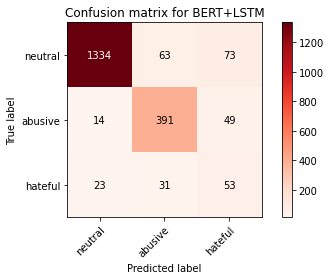

In [0]:
test_model()